<a href="https://colab.research.google.com/github/beltsazar1/project_pi_dataMining/blob/main/projrct_pi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
from branca.element import MacroElement
from jinja2 import Template

from google.colab import files
import io

In [2]:
uploaded = files.upload()

Saving tourism_with_id.csv to tourism_with_id.csv


In [3]:
for filename in uploaded.keys():
  df = pd.read_csv(io.BytesIO(uploaded[filename]))
  print(f"File '{filename}' loaded succesfully.\n")
  print(df.head())

File 'tourism_with_id.csv' loaded succesfully.

   Place_Id                         Place_Name  \
0         1                   Monumen Nasional   
1         2                           Kota Tua   
2         3                      Dunia Fantasi   
3         4  Taman Mini Indonesia Indah (TMII)   
4         5           Atlantis Water Adventure   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   
4  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan  Jakarta   

    Price  Rating  Time_Minutes  \
0   20000     4.6          15.0   
1       0     4.6          90.0   
2  270000     4.6         360.0   
3   10000     4.5           Na

In [4]:
df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(['Unnamed: 11', 'Unnamed: 12'], axis=1)
df_cleaned.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


In [5]:
print("Missing Values:\n", df_cleaned.isnull().sum())

median = df_cleaned["Time_Minutes"].median()
df_cleaned.fillna({"Time_Minutes": median}, inplace=True)

if df_cleaned.isnull().values.any():
  print("There are still missing values in the dataset.")
else:
  print("\n", df_cleaned.isnull().sum())
  print("\nThere are no missing values in the dataset.")

df_cleaned.head()

Missing Values:
 Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
dtype: int64

 Place_Id        0
Place_Name      0
Description     0
Category        0
City            0
Price           0
Rating          0
Time_Minutes    0
Coordinate      0
Lat             0
Long            0
dtype: int64

There are no missing values in the dataset.


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,60.0,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


In [6]:
non_categorical_column = df_cleaned.select_dtypes(include=[np.number]).columns

def remove_outliers(df, columns):
  df_no_outliers = df_cleaned.copy()
  for col in columns:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    return df_no_outliers

df_iqr_removed = remove_outliers(df, non_categorical_column)
df_iqr_removed.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,60.0,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134


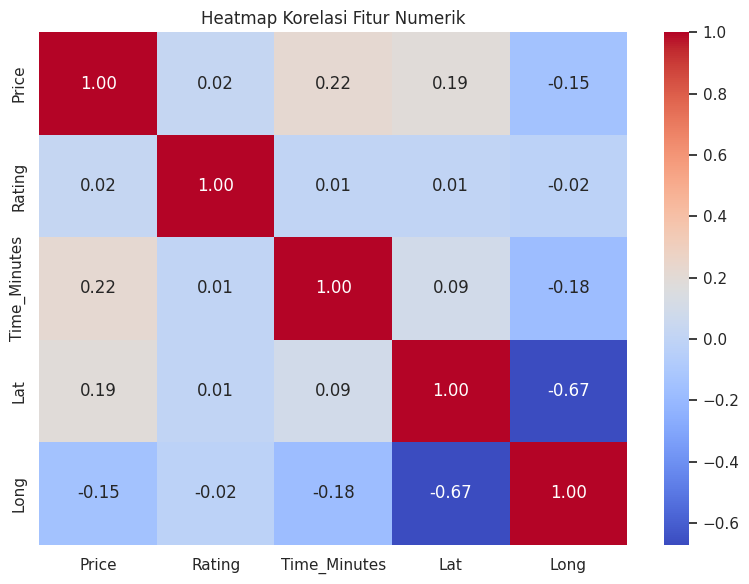

In [20]:
plt.figure(figsize=(8, 6))
corr = df_iqr_removed[["Price", "Rating", "Time_Minutes", "Lat", "Long"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi Fitur Numerik")
plt.tight_layout()
plt.show()

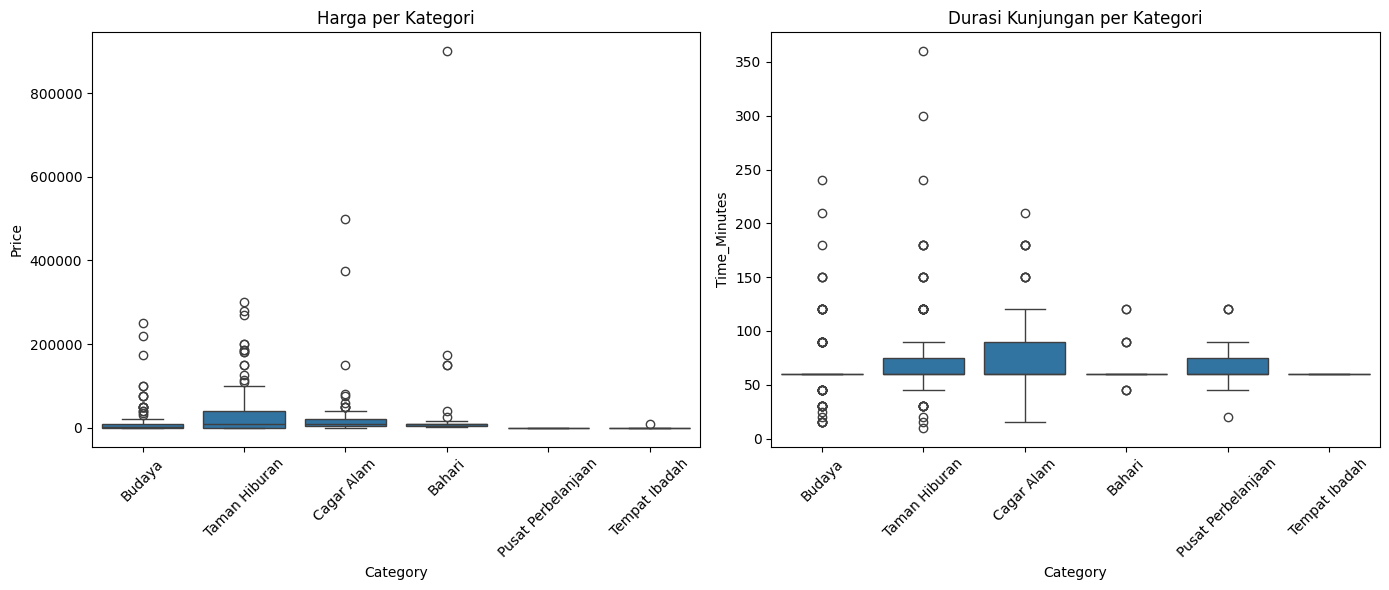

In [8]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_iqr_removed, x="Category", y="Price")
plt.xticks(rotation=45)
plt.title("Harga per Kategori")

plt.subplot(1, 2, 2)
sns.boxplot(data=df_iqr_removed, x="Category", y="Time_Minutes")
plt.xticks(rotation=45)
plt.title("Durasi Kunjungan per Kategori")

plt.tight_layout()
plt.show()


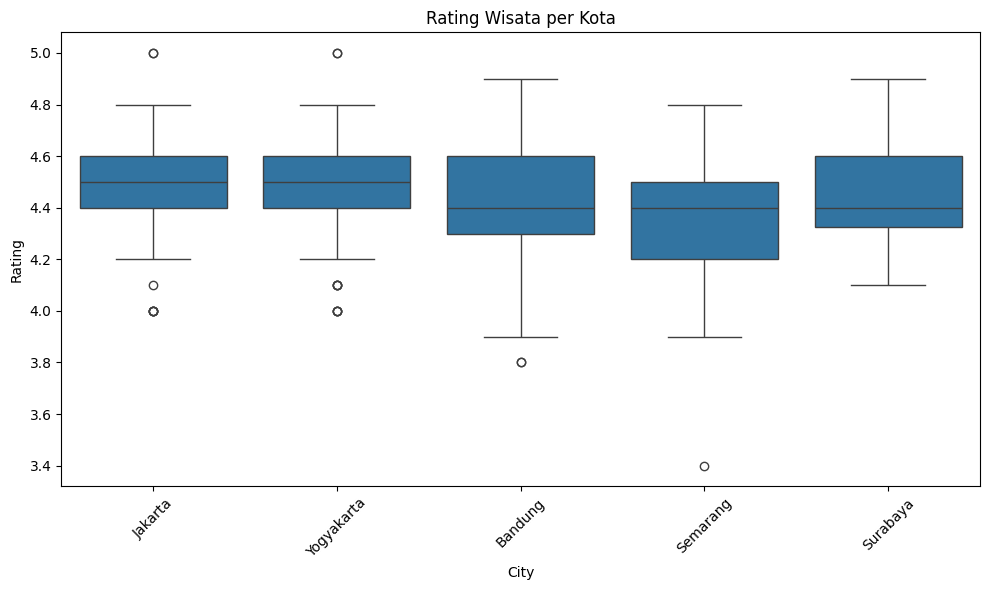

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_iqr_removed, x="City", y="Rating")
plt.xticks(rotation=45)
plt.title("Rating Wisata per Kota")
plt.tight_layout()
plt.show()

In [23]:
# plt.figure(figsize=(10, 6))
# scatter = plt.scatter(df_iqr_removed["Long"], df_iqr_removed["Lat"],
 #                     c=df_iqr_removed["Price"], cmap="viridis", alpha=0.7)
# plt.colorbar(scatter, label="Harga")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.title("Sebaran Lokasi Wisata Berdasarkan Harga")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

#nanti ubah kedalam bentuk map

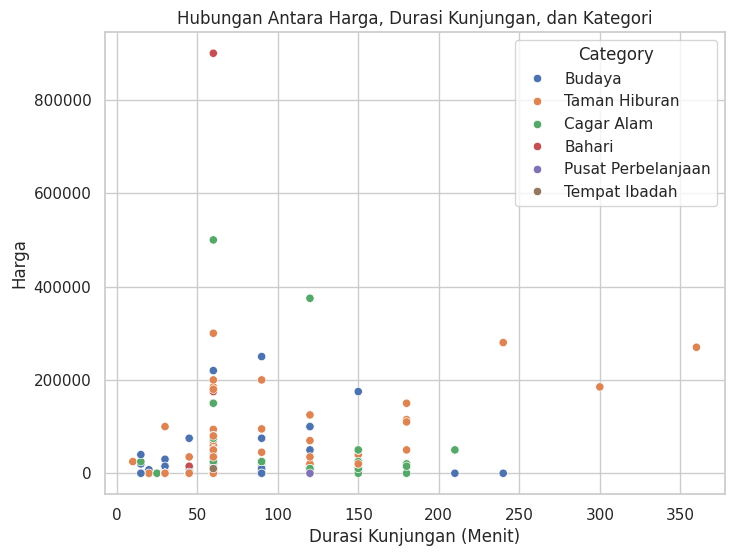

In [25]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_iqr_removed, x='Time_Minutes', y='Price', hue='Category')
plt.title('Hubungan Antara Harga, Durasi Kunjungan, dan Kategori')
plt.xlabel('Durasi Kunjungan (Menit)')
plt.ylabel('Harga')
plt.show()

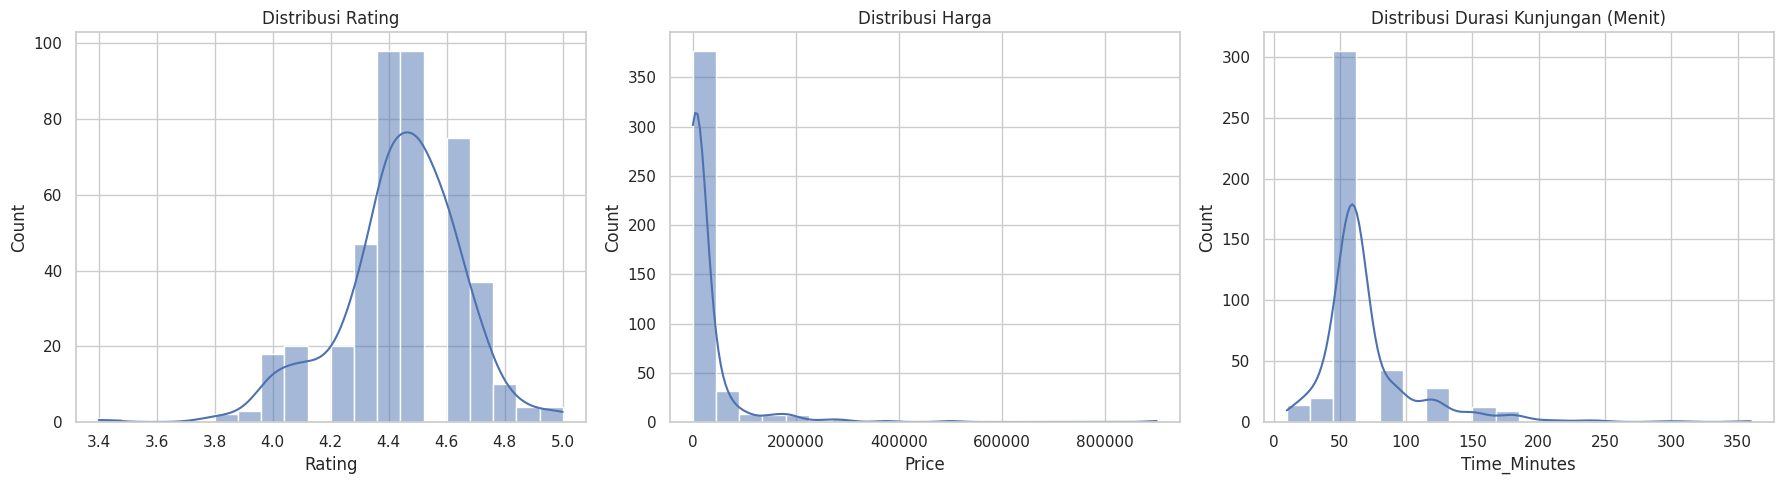

In [11]:
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(df_iqr_removed['Rating'], bins=20, kde=True)
plt.title('Distribusi Rating')

plt.subplot(1, 3, 2)
sns.histplot(df_iqr_removed['Price'], bins=20, kde=True)
plt.title('Distribusi Harga')

plt.subplot(1, 3, 3)
sns.histplot(df_iqr_removed['Time_Minutes'], bins=20, kde=True)
plt.title('Distribusi Durasi Kunjungan (Menit)')

plt.tight_layout()
plt.show()


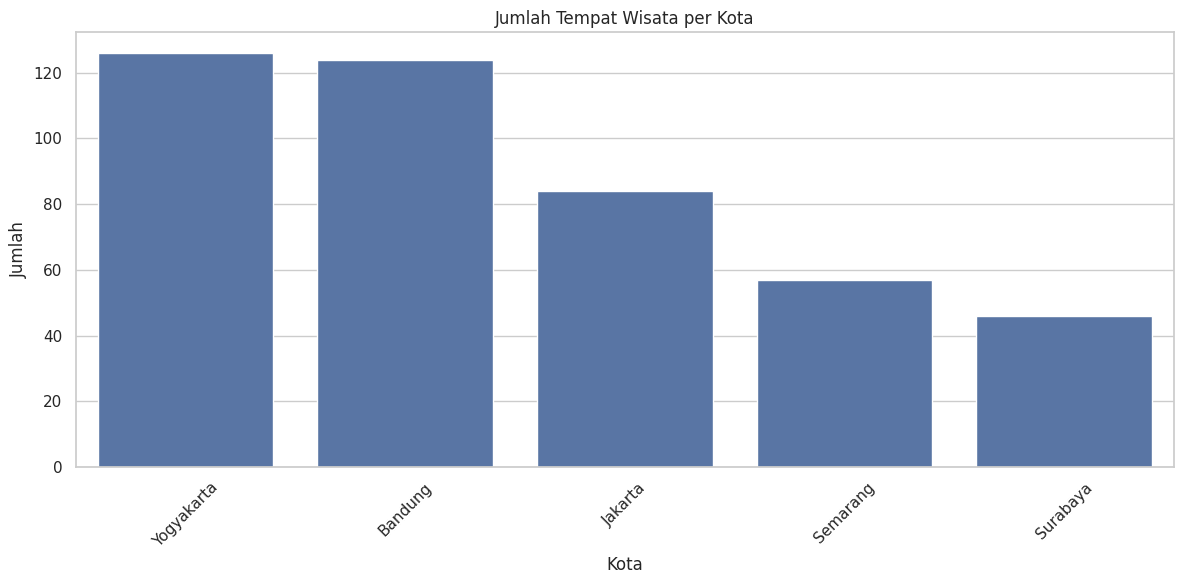

In [12]:
plt.figure(figsize=(12, 6))
city_count = df_iqr_removed["City"].value_counts()
sns.barplot(x=city_count.index, y=city_count.values)
plt.xticks(rotation=45)
plt.title("Jumlah Tempat Wisata per Kota")
plt.ylabel("Jumlah")
plt.xlabel("Kota")
plt.tight_layout()
plt.show()

/tmp/ipython-input-13-3142817757.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_cat.index, y=avg_rating_cat.values, palette="Set2")


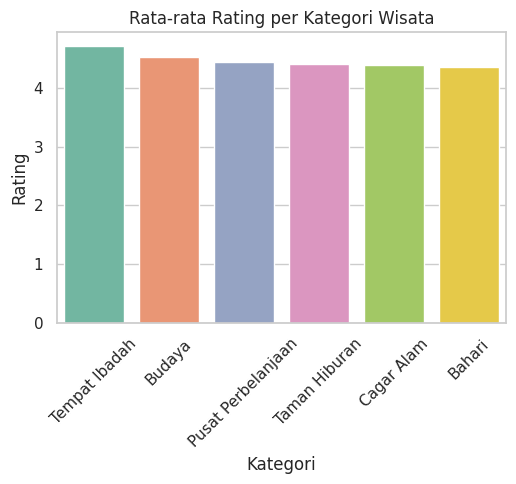

/tmp/ipython-input-13-3142817757.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_city.index, y=avg_rating_city.values, palette="Set2")


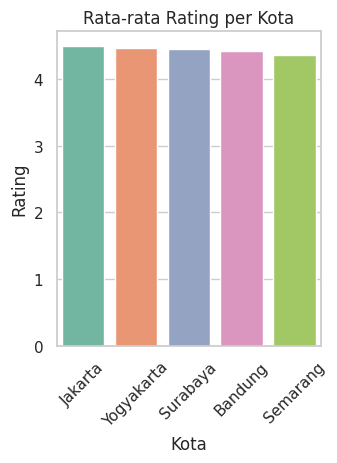

In [13]:
plt.figure(figsize=(10, 5))
avg_rating_cat = df_iqr_removed.groupby("Category")["Rating"].mean().sort_values(ascending=False)

avg_rating_city = df_iqr_removed.groupby("City")["Rating"].mean().sort_values(ascending=False)

plt.subplot(1, 2, 1)
sns.barplot(x=avg_rating_cat.index, y=avg_rating_cat.values, palette="Set2")
plt.xticks(rotation=45)
plt.title("Rata-rata Rating per Kategori Wisata")
plt.ylabel("Rating")
plt.xlabel("Kategori")
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 2)
sns.barplot(x=avg_rating_city.index, y=avg_rating_city.values, palette="Set2")
plt.xticks(rotation=45)
plt.title("Rata-rata Rating per Kota")
plt.ylabel("Rating")
plt.xlabel("Kota")
plt.tight_layout()
plt.show()

In [14]:
import matplotlib.cm as cm_mpl

min_price = df_iqr_removed["Price"].min()
max_price = df_iqr_removed["Price"].max()

# Create a linear colormap from branca using a matplotlib colormap
colormap = cm.LinearColormap(
    colors=[cm_mpl.viridis(i) for i in range(256)],
    index=np.linspace(min_price, max_price, 256),
    caption='Harga Tiket (Rp)'
)

map_wisata = folium.Map(location=[-6.2, 106.8], zoom_start=6)
marker_cluster = MarkerCluster().add_to(map_wisata)

for _, row in df_iqr_removed.iterrows():
    folium.CircleMarker(
        location=[row["Lat"], row["Long"]],
        radius=5,
        color=colormap(row["Price"]),
        fill=True,
        fill_color=colormap(row["Price"]),
        fill_opacity=0.8,
        tooltip=f"<b>{row['Place_Name']}</b><br>Harga: Rp{row['Price']}<br>Rating: {row['Rating']}"
    ).add_to(marker_cluster)

colormap.add_to(map_wisata)
map_wisata

In [15]:
features = df_iqr_removed[["Rating", "Price", "Time_Minutes"]].copy()

scaler = StandardScaler()
scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # Added n_init to suppress warning
df_iqr_removed["Cluster"] = kmeans.fit_predict(scaled)

summary = df_iqr_removed.copy().groupby("Cluster")[["Rating", "Price", "Time_Minutes"]].agg(["mean", "median", "min", "max"]).round(2)
summary

count = df_iqr_removed["Cluster"].value_counts().sort_index()
print("Jumlah tempat wisata per cluster:\n", count)

cluster_means = df_iqr_removed.copy().groupby("Cluster")[["Rating", "Price", "Time_Minutes"]].mean().round(2)
print("\nRata-rata rating, harga, dan durasi kunjungan per cluster:\n", cluster_means)

for cluster_id, row in cluster_means.iterrows():
    print(f"\n🔹 Cluster {cluster_id}:")
    if row["Price"] < 20000:
        harga = "murah"
    elif row["Price"] < 100000:
        harga = "sedang"
    else:
        harga = "mahal"

    if row["Time_Minutes"] < 60:
        durasi = "singkat"
    elif row["Time_Minutes"] < 100:
        durasi = "sedang"
    else:
        durasi = "lama"

    if row["Rating"] >= 4.5:
        rating = "sangat tinggi"
    elif row["Rating"] >= 4.2:
        rating = "tinggi"
    else:
        rating = "cukup"

    print(f"- Rating rata-rata: {row['Rating']} ({rating})")
    print(f"- Harga rata-rata: Rp{int(row['Price'])} ({harga})")
    print(f"- Durasi kunjungan: {int(row['Time_Minutes'])} menit ({durasi})")

Jumlah tempat wisata per cluster:
 Cluster
0    279
1     98
2      8
3     52
Name: count, dtype: int64

Rata-rata rating, harga, dan durasi kunjungan per cluster:
          Rating      Price  Time_Minutes
Cluster                                 
0          4.54   13378.14         58.82
1          4.16   17826.53         59.85
2          4.47  368125.00         75.00
3          4.44   45163.46        153.46

🔹 Cluster 0:
- Rating rata-rata: 4.54 (sangat tinggi)
- Harga rata-rata: Rp13378 (murah)
- Durasi kunjungan: 58 menit (singkat)

🔹 Cluster 1:
- Rating rata-rata: 4.16 (cukup)
- Harga rata-rata: Rp17826 (murah)
- Durasi kunjungan: 59 menit (singkat)

🔹 Cluster 2:
- Rating rata-rata: 4.47 (tinggi)
- Harga rata-rata: Rp368125 (mahal)
- Durasi kunjungan: 75 menit (sedang)

🔹 Cluster 3:
- Rating rata-rata: 4.44 (tinggi)
- Harga rata-rata: Rp45163 (sedang)
- Durasi kunjungan: 153 menit (lama)


/tmp/ipython-input-16-3904341597.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_iqr_removed, x="Cluster", y="Rating", palette="Set2")
/tmp/ipython-input-16-3904341597.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_iqr_removed, x="Cluster", y="Price", palette="Set2")


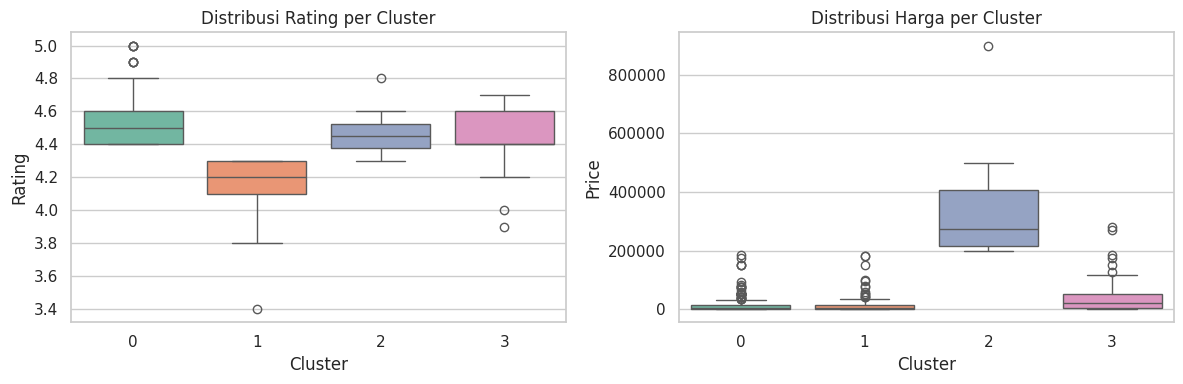

/tmp/ipython-input-16-3904341597.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_iqr_removed, x="Cluster", y="Time_Minutes", palette="Set2")


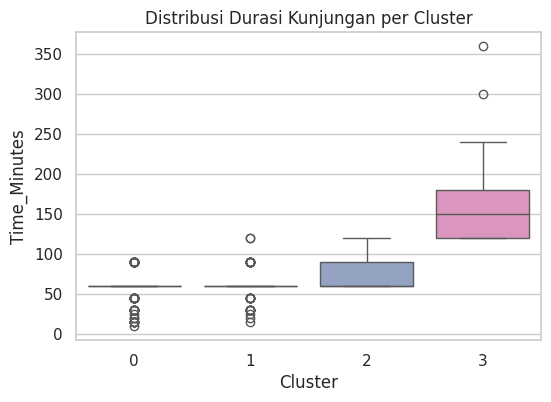

In [16]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_iqr_removed, x="Cluster", y="Rating", palette="Set2")
plt.title("Distribusi Rating per Cluster")

plt.subplot(1, 2, 2)
sns.boxplot(data=df_iqr_removed, x="Cluster", y="Price", palette="Set2")
plt.title("Distribusi Harga per Cluster")

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=df_iqr_removed, x="Cluster", y="Time_Minutes", palette="Set2")
plt.title("Distribusi Durasi Kunjungan per Cluster")
plt.show()

In [17]:
cluster_colors = ['red', 'blue', 'purple', 'green']
map_clustered = folium.Map(location=[-6.5, 107], zoom_start=6)
marker_cluster = MarkerCluster().add_to(map_clustered)

for _, row in df_iqr_removed.iterrows():
    cid = row["Cluster"]
    folium.CircleMarker(
        location=[row["Lat"], row["Long"]],
        radius=5,
        color=cluster_colors[cid],
        fill=True,
        fill_color=cluster_colors[cid],
        fill_opacity=0.8,
        tooltip=(
            f"<b>{row['Place_Name']}</b><br>"
            f"Rating: {row['Rating']}<br>"
            f"Harga: Rp{int(row['Price'])}<br>"
            f"Durasi: {int(row['Time_Minutes'])} menit<br>"
            f"Cluster: {cid}"
        )
    ).add_to(marker_cluster)

# Tambahkan legend (keterangan cluster)
legend_html = """
{% macro html(this, kwargs) %}
<div style="
    position: fixed;
    top: 50px;
    right: 50px;
    z-index: 9999;
    background-color: white;
    padding: 10px;
    border: 2px solid grey;
    border-radius: 5px;
    box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
">
    <h4 style="margin-top:0">Cluster Legend</h4>
    <ul style="list-style: none; padding: 0; margin: 0;">
        <li><span style="background:red; width:10px; height:10px; display:inline-block; margin-right:6px;"></span>Cluster 0</li>
        <li><span style="background:blue; width:10px; height:10px; display:inline-block; margin-right:6px;"></span>Cluster 1</li>
        <li><span style="background:purple; width:10px; height:10px; display:inline-block; margin-right:6px;"></span>Cluster 2</li>
        <li><span style="background:green; width:10px; height:10px; display:inline-block; margin-right:6px;"></span>Cluster 3</li>
    </ul>
</div>
{% endmacro %}
"""
legend = MacroElement()
legend._template = Template(legend_html)
map_clustered.get_root().add_child(legend)